In [99]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
import cmocean
from gsw import rho

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [100]:
%cd /net2/smg/documents/OMDT/analysis_CM2p6/grids
os = xr.open_dataset('ocean.static.nc')
fs=xr.open_dataset('ocean_grid.nc')
depth=fs['ht'][:,:]

lon=fs['geolon_t']; lat=fs['geolat_t']
# Coriolis is 2Omega sin(phi) where phi is the latitude of the B-grid velocity point, which should be available in hgrid
Coriolis = 2*7.29e-5*np.sin(fs['geolat_t']/360 *2*np.pi);
#dx = fs['dxt']; dy = fs['dyt']; dxy= (dx**2+dy**2)**0.5
#print(os,fs)

/net2/smg/documents/OMDT/analysis_CM2p6/grids


### For CM2.6 data:

In [101]:
%cd /archive/Richard.Slater/CM2.6/CM2.6_A_Control-1860_V03/history

u = xr.open_dataset('02020101.ocean_minibling_field_u.nc')['u']
v = xr.open_dataset('02020101.ocean_minibling_field_v.nc')['v']
salt = xr.open_dataset('02020101.ocean_minibling_field_salt.nc')['salt']
temp = xr.open_dataset('02020101.ocean_minibling_field_temp.nc')['temp']

z = u.st_ocean
z_edges  = xr.open_dataset('02020101.ocean_minibling_field_u.nc')['st_edges_ocean']
thickness= z_edges.diff('st_edges_ocean').rename({'st_edges_ocean': 'st_ocean'}).assign_coords({"st_ocean":u.st_ocean})

print(thickness)

/arch2/rds/CM2.6/CM2.6_A_Control-1860_V03/history
<xarray.DataArray 'st_edges_ocean' (st_ocean: 50)>
array([ 10.06709957,  10.09290028,  10.12890053,  10.17849922,
        10.24740219,  10.34269714,  10.47480392,  10.6576004 ,
        10.9101944 ,  11.25960541,  11.74169922,  12.40619659,
        13.32000732,  14.57260132,  16.28289795,  18.604599  ,
        21.73239136,  25.90260315,  31.3868103 ,  38.4697876 ,
        47.40710449,  58.35928345,  71.30871582,  85.9883728 ,
       101.85479736, 118.14520264, 134.01159668, 148.69128418,
       161.64074707, 172.59289551, 181.53027344, 188.61315918,
       194.09741211, 198.26745605, 201.39550781, 203.71704102,
       205.42749023, 206.67993164, 207.59399414, 208.25805664,
       208.74047852, 209.08984375, 209.34228516, 209.52539062,
       209.65722656, 209.75244141, 209.82177734, 209.87109375,
       209.90673828, 209.93310547])
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03


In [102]:
%%time 
density_np = rho(salt[-1,:,:,:],temp[-1,:,:,:],0)
density = xr.DataArray(density_np,dims   = ['st_ocean','yt_ocean','xt_ocean'],
                       coords={'yt_ocean':temp.yt_ocean,
                               'xt_ocean':temp.xt_ocean,
                               'st_ocean':temp.st_ocean})
#print(density)

CPU times: user 12.1 s, sys: 8.61 s, total: 20.7 s
Wall time: 21 s


In [103]:
%cd /work/eay/CM2.6

BTBC_KE = xr.open_dataset('CM2.6_Ratio_BTBC_KE_mean.nc')['Ratio_BTBC_KE'].rename({'yu_ocean':'yt_ocean','xu_ocean': 'xt_ocean'}).assign_coords({'yt_ocean':Coriolis.yt_ocean,'xt_ocean':Coriolis.xt_ocean})

print(BTBC_KE)

/work2/eay/CM2.6
<xarray.DataArray 'Ratio_BTBC_KE' (yt_ocean: 2700, xt_ocean: 3600)>
[9720000 values with dtype=float64]
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    st_ocean  float64 ...


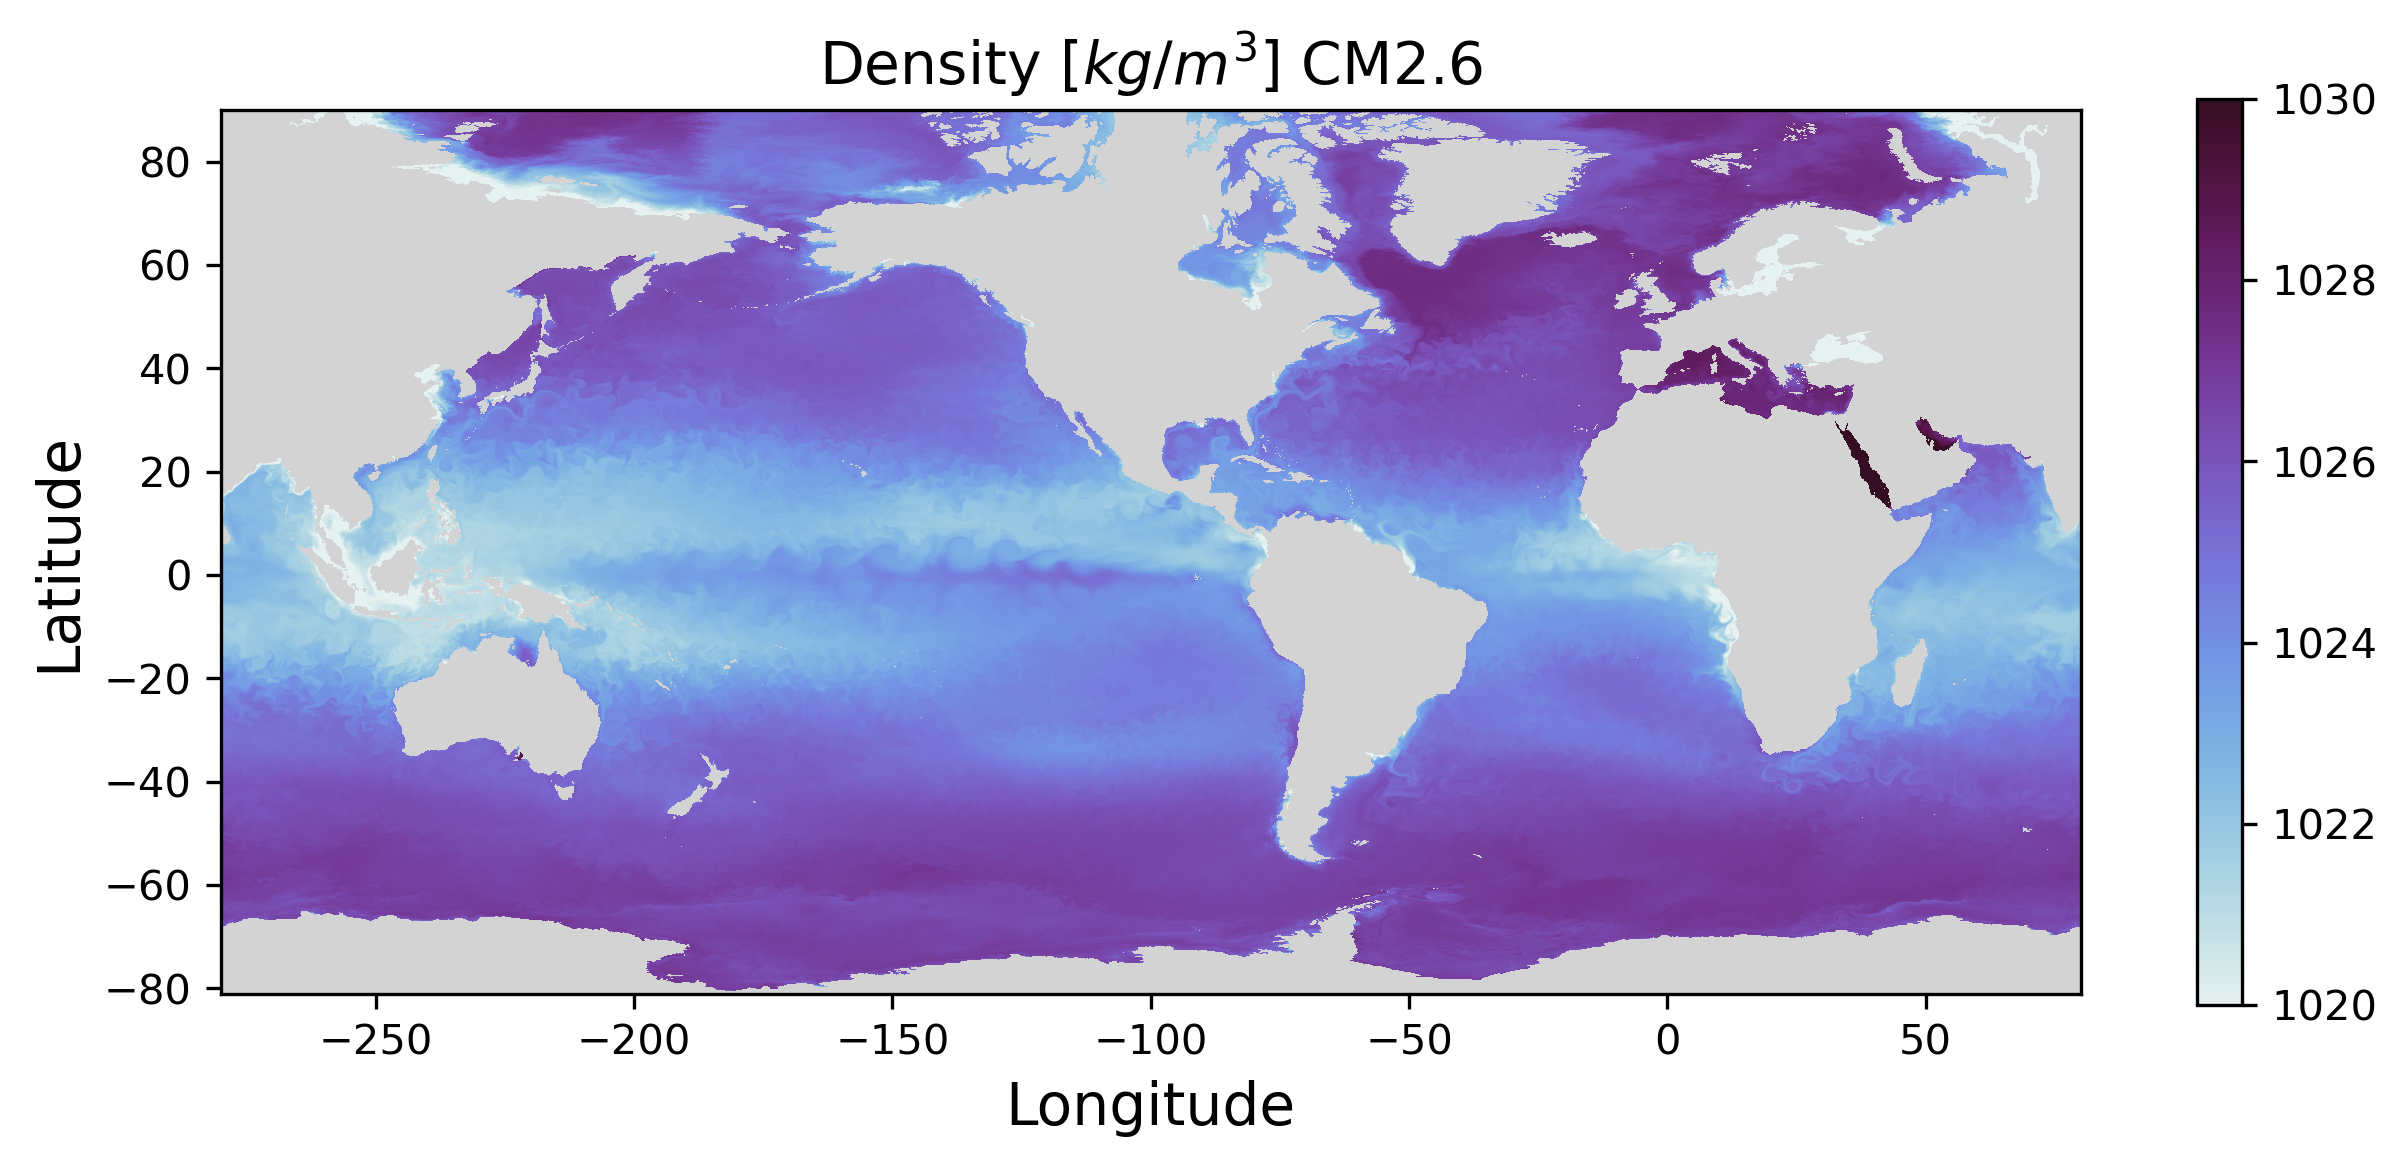

In [104]:
fig = plt.figure(figsize=(10, 4), dpi= 300, facecolor='w', edgecolor='k')

plot1=density[0,:,:].plot(vmin=1020,vmax=1030,cmap=cmocean.cm.dense,add_colorbar=False)#,xlim=[-70,-10],ylim=[-70,-20])
plt.colorbar(plot1)
#hatch = plt.fill_between([-180,-130],-70,50,color="none",edgecolor='k')

current_cmap = plot1.get_cmap()
current_cmap.set_bad(color='#D3D3D3')

plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitude',fontsize=14)
plt.title('Density [$kg/m^3$] CM2.6',fontsize=14)
plt.gca().set_aspect('equal')
#

In [105]:
print(np.nanmean(density[0,:]))
density.shape

1025.2200017948326


(50, 2700, 3600)

In [106]:
mask = density[:,:,:]*0+1.
thickness_full = mask*thickness
positions = thickness_full.cumsum('st_ocean')*mask


[-0.00161271 -0.29558292]
620.0759432822391


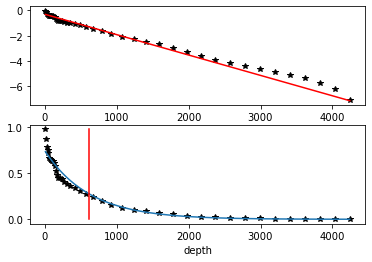

In [107]:
##Testing the curve fitting at one location

ind1 = 500
ind2 = 500

local_rho   = density[:,ind1,ind2].dropna('st_ocean')
local_rho   = abs(local_rho-local_rho[-1])
local_layer = positions[:,ind1,ind2].dropna('st_ocean')

x = local_layer[:-2]
y = local_rho[:-2]
plt.subplot(2,1,1)
plt.plot(x,np.log(y),'*k')
A = np.polyfit(x,np.log(y),1,w=np.sqrt(y))
print(A)
plt.plot(x,A[1]+x*A[0],'r-')

plt.subplot(2,1,2)
plt.plot(x,y,'*k')
plt.plot(x,np.exp(A[1]+x*A[0]))
plt.plot([abs(1/A[0]),abs(1/A[0])],[0,np.max(y)],'r')
plt.xlabel('depth')
#plt.ylabel('buoyancy anomaly ($kg/m^3$)')
depths = np.abs(1/A[0])
print(depths)

In [109]:
density_coarse   = density.coarsen(yt_ocean=5,xt_ocean=5, boundary="exact").mean()
positions_coarse = positions.coarsen(yt_ocean=5,xt_ocean=5, boundary="exact").mean()

In [ ]:
# ##Curve fitting for all locations
# depths = xr.zeros_like(density_coarse[0,:,:])
# for i in range(540):
#     print(i)
#     for j in range(720):
#         local_rho   = density_coarse[:,i,j].dropna('st_ocean')
#         if local_rho.size > 4:
#             local_rho   = abs(local_rho-local_rho[-1])
#             local_layer = positions_coarse[:,i,j].dropna('st_ocean')

#             x = local_layer[:-2]
#             y = local_rho[:-2]
#             A = np.polyfit(x,np.log(y),1)
#             depths[i,j] = np.abs(1/A[0])

In [110]:
# %cd /work/eay/CM2.6
# ds = xr.Dataset({'depths': (depths)})
# print('done')
# ds.to_netcdf('Scale_depths_CM2.6.nc', 'w')

depths = xr.open_dataset('Scale_depths_CM2.6.nc')['depths']

In [111]:
depth_ratio = depths/depth.coarsen(yt_ocean=5,xt_ocean=5, boundary="exact").mean()
depth_ratio.shape


(540, 720)

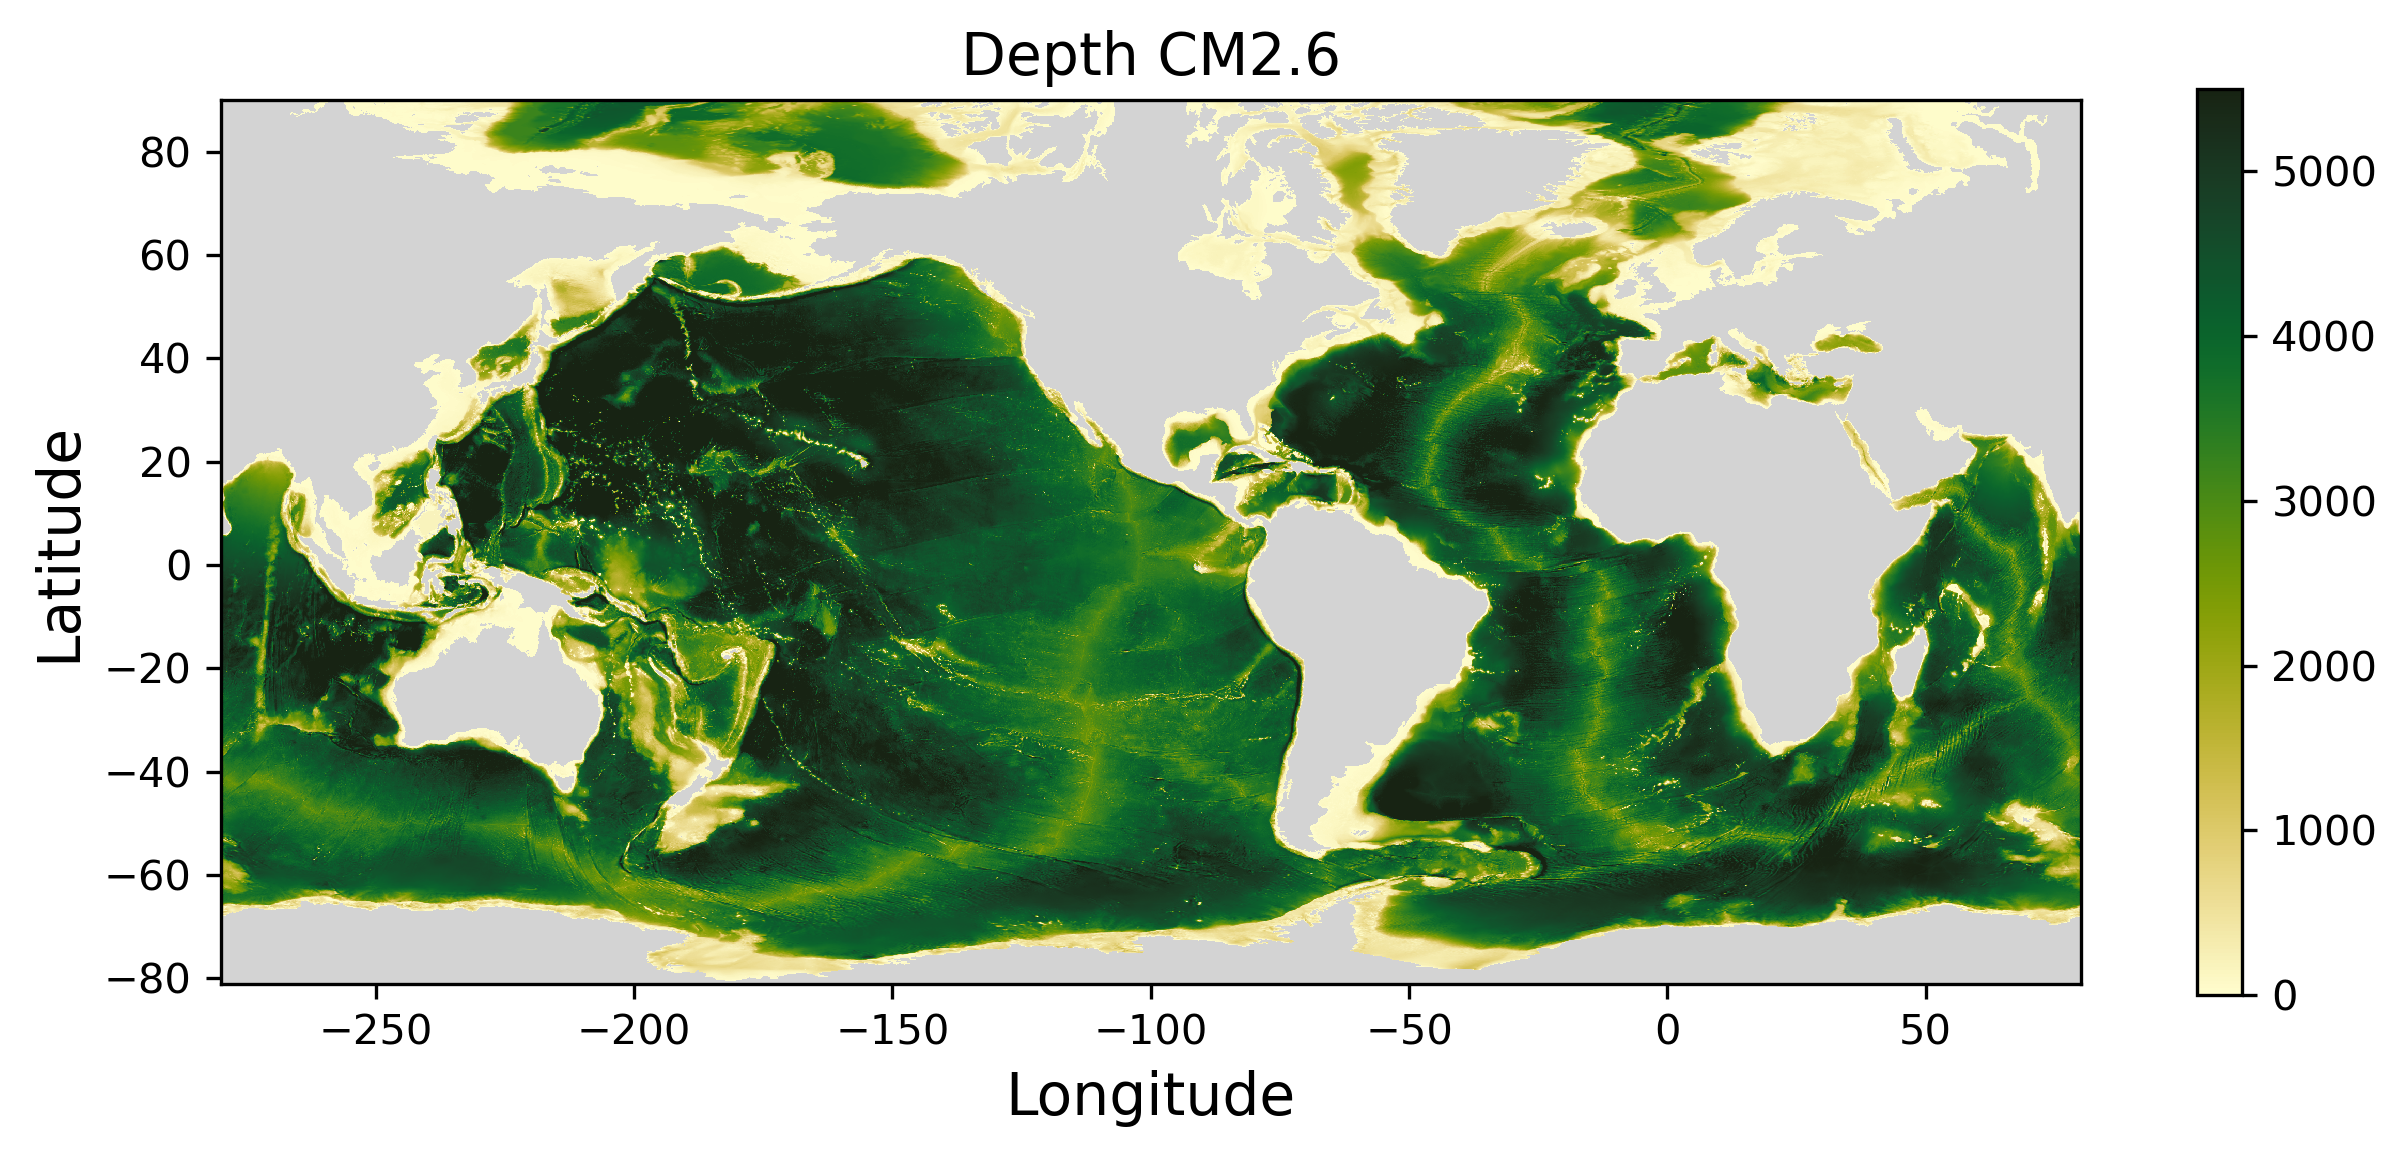

In [136]:
fig = plt.figure(figsize=(10, 4), dpi= 300, facecolor='w', edgecolor='k')

plot1=depth.plot(vmin=0.,vmax=5500,cmap=cmocean.cm.speed,add_colorbar=False)#,xlim=[-70,-10],ylim=[-70,-20])
plt.colorbar(plot1)
#hatch = plt.fill_between([-180,-130],-70,50,color="none",edgecolor='k')

current_cmap = plot1.get_cmap()
current_cmap.set_bad(color='#D3D3D3')

plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitude',fontsize=14)
plt.title('Depth CM2.6',fontsize=14)
plt.gca().set_aspect('equal')
#

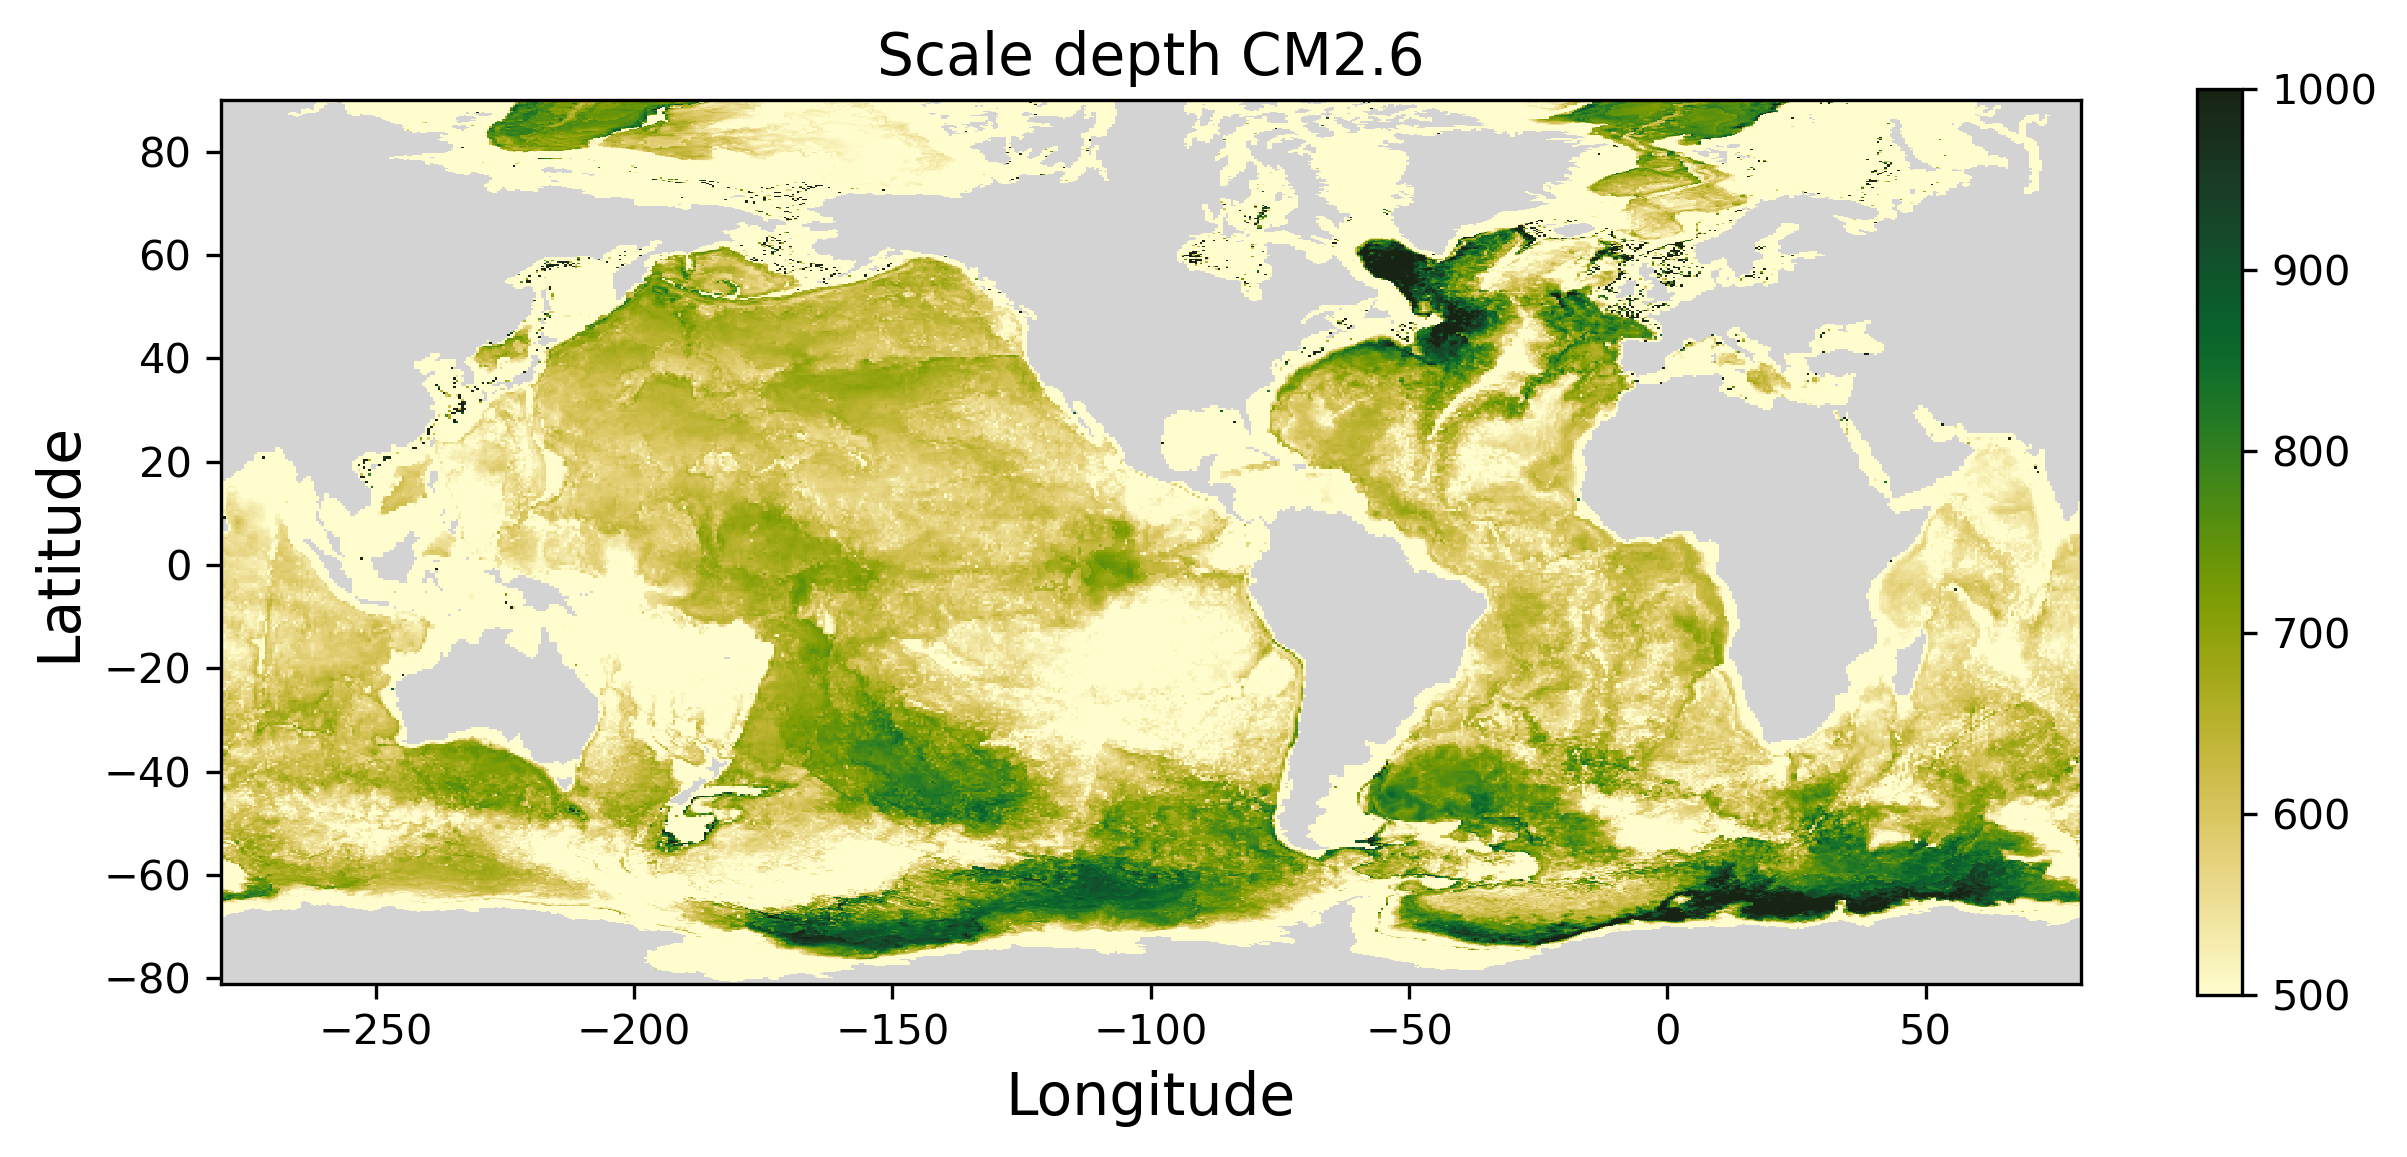

In [135]:
fig = plt.figure(figsize=(10, 4), dpi= 300, facecolor='w', edgecolor='k')

plot1=depths.plot(vmin=500.,vmax=1000,cmap=cmocean.cm.speed,add_colorbar=False)#,xlim=[-70,-10],ylim=[-70,-20])
plt.colorbar(plot1)
#hatch = plt.fill_between([-180,-130],-70,50,color="none",edgecolor='k')

current_cmap = plot1.get_cmap()
current_cmap.set_bad(color='#D3D3D3')

plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitude',fontsize=14)
plt.title('Scale depth CM2.6',fontsize=14)
plt.gca().set_aspect('equal')
#

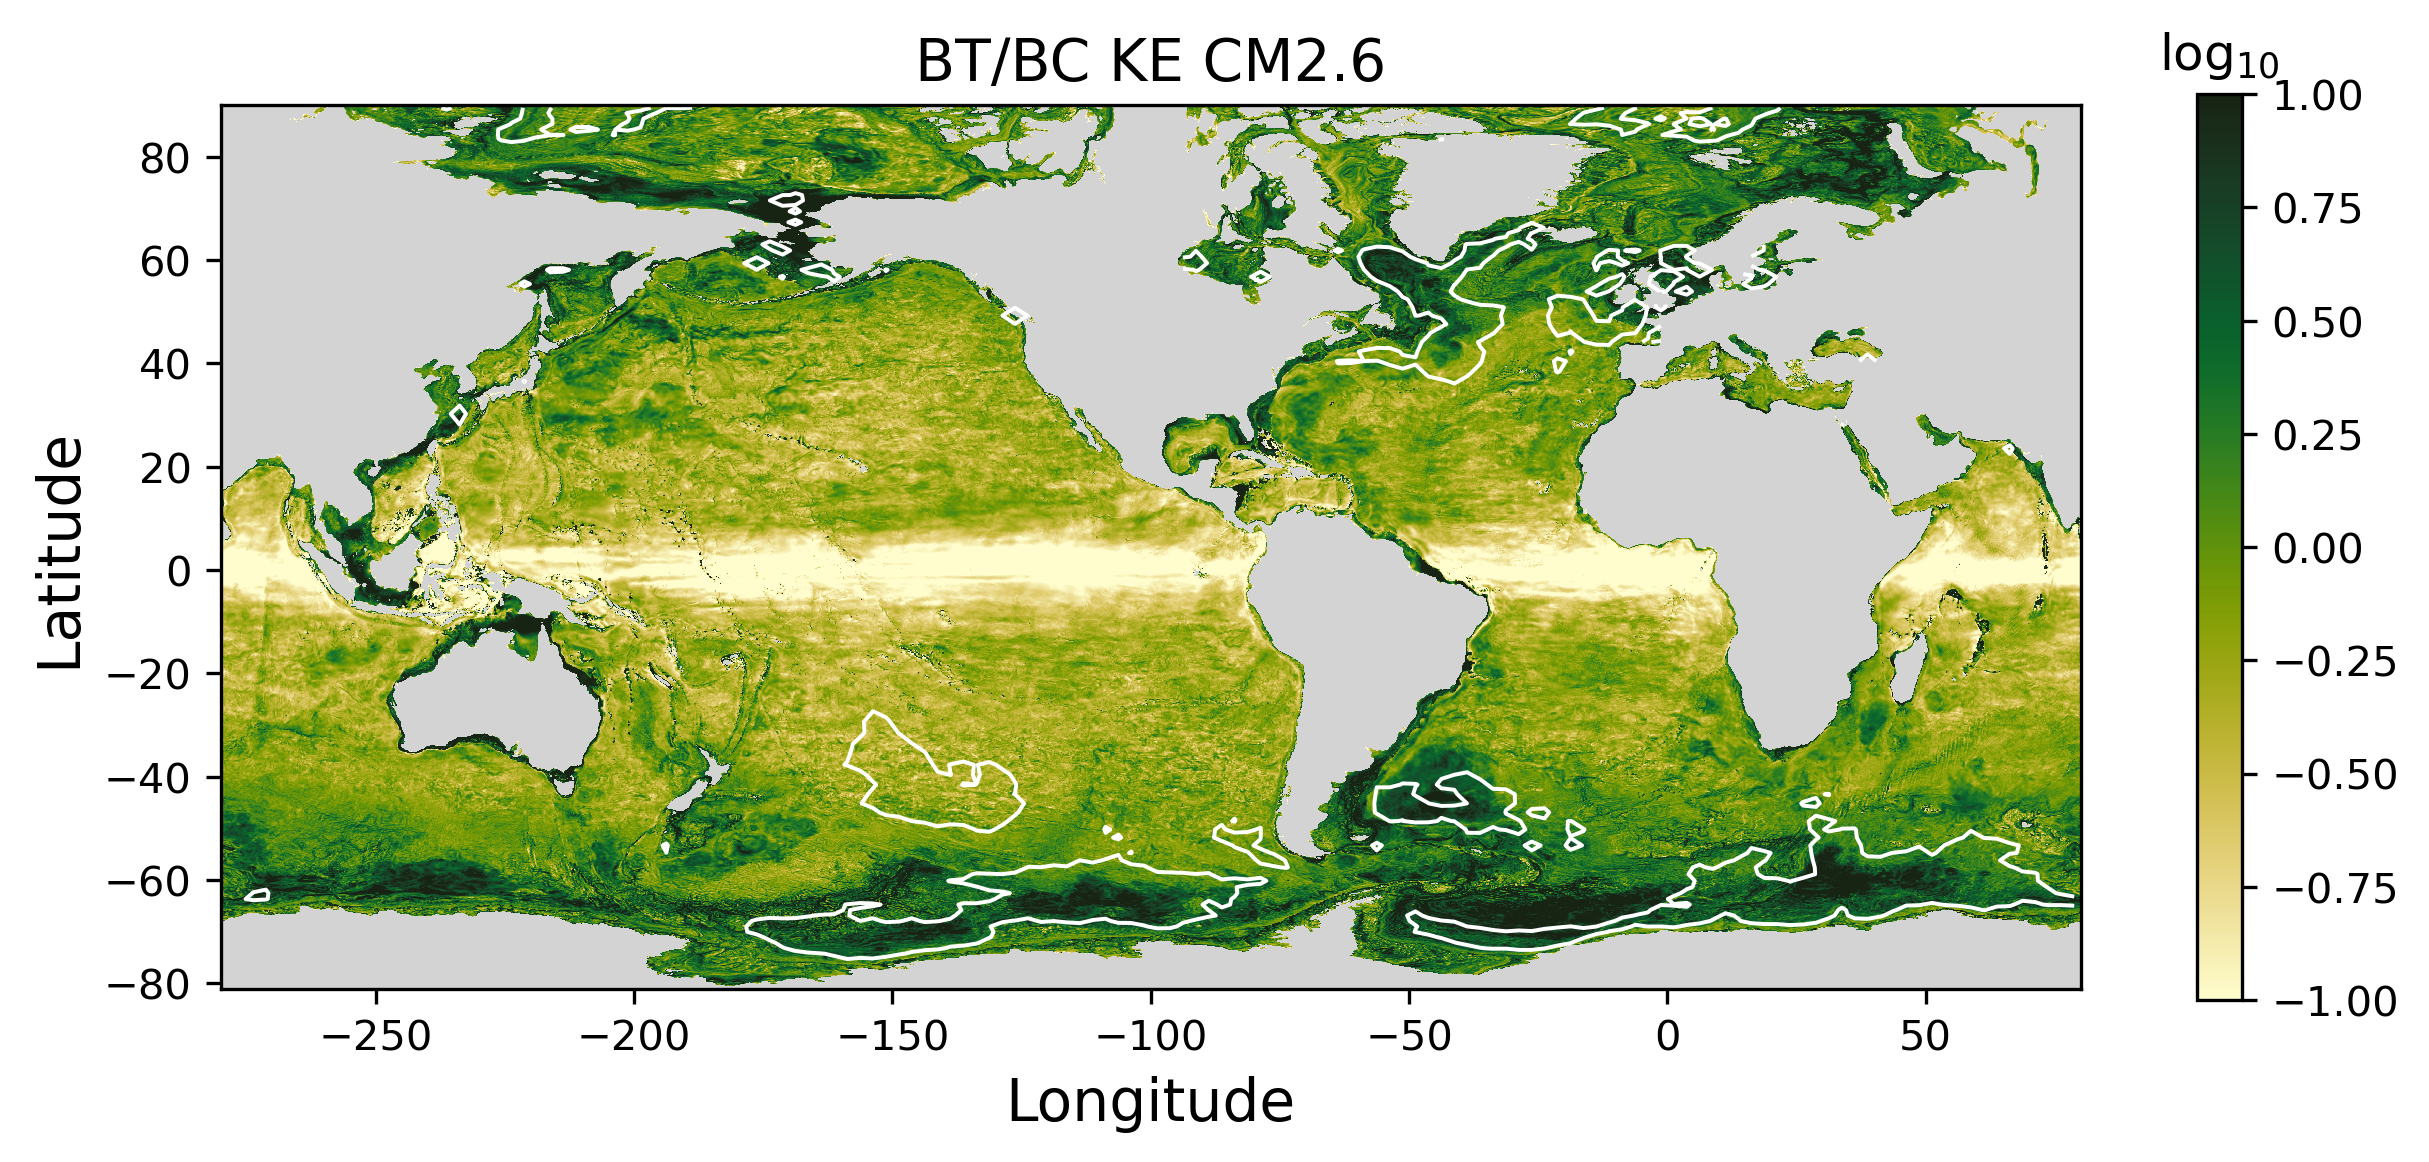

In [151]:
fig = plt.figure(figsize=(10, 4), dpi= 300, facecolor='w', edgecolor='k')

plot1=xr.ufuncs.log10(BTBC_KE).plot(vmin=-1,vmax=1,cmap=cmocean.cm.speed,add_colorbar=False)#,xlim=[-70,-10],ylim=[-70,-20])
cbar=plt.colorbar(plot1)

#hatch = plt.fill_between([-180,-130],-70,50,color="none",edgecolor='k')
#(depths.coarsen(yt_ocean=5,xt_ocean=5, boundary="exact").mean()).plot.contour(levels=[500], colors='k', linewidths=0.95)
(depths.coarsen(yt_ocean=5,xt_ocean=5, boundary="exact").mean()).plot.contour(levels=[750], colors='w', linewidths=0.95)
#(depth_ratio.coarsen(yt_ocean=5,xt_ocean=5, boundary="exact").mean()).plot.contour(levels=[0.2], colors='m', linewidths=0.95)

current_cmap = plot1.get_cmap()
current_cmap.set_bad(color='#D3D3D3')
cbar.ax.set_title('log$_{10}$')

plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitude',fontsize=14)
plt.title('BT/BC KE CM2.6',fontsize=14)
plt.gca().set_aspect('equal')
#
plt.show()

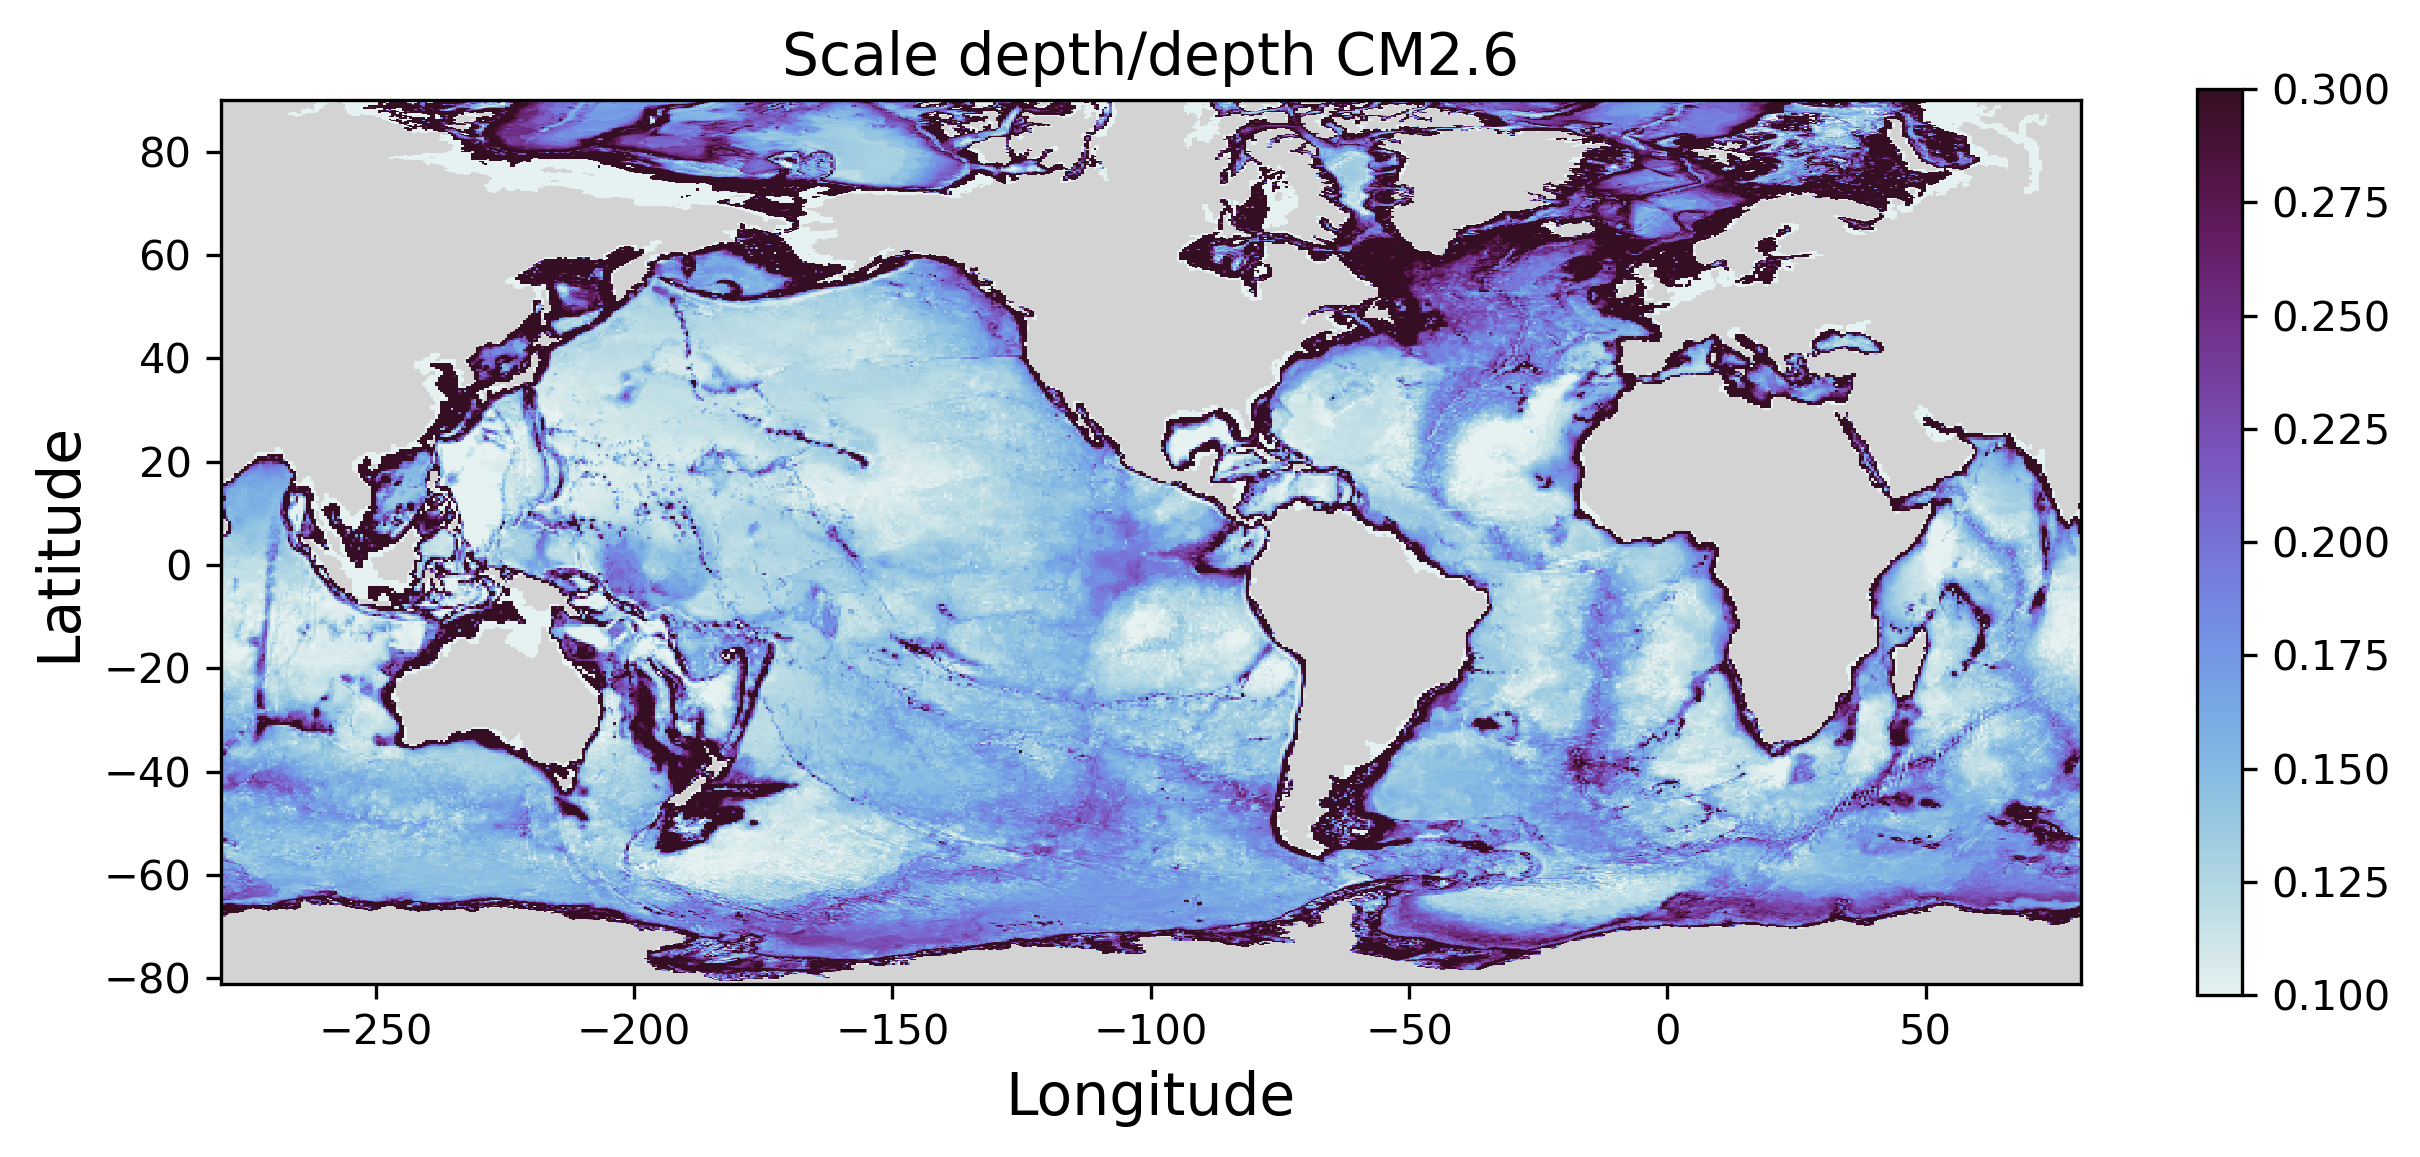

In [138]:
fig = plt.figure(figsize=(10, 4), dpi= 300, facecolor='w', edgecolor='k')

plot1=depth_ratio.plot(vmin=.1,vmax=.3,cmap=cmocean.cm.dense,add_colorbar=False)#,xlim=[-70,-10],ylim=[-70,-20])
plt.colorbar(plot1)

current_cmap = plot1.get_cmap()
current_cmap.set_bad(color='#D3D3D3')

plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitude',fontsize=14)
plt.title('Scale depth/depth CM2.6',fontsize=14)
plt.gca().set_aspect('equal')
#

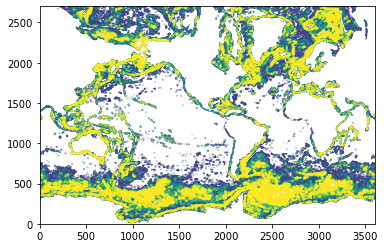

In [88]:
plt.contour(BTBC_KE, levels=np.linspace(0,10,6),linewidth=1)

In [87]:
np.linspace(0,10,6)

array([ 0.,  2.,  4.,  6.,  8., 10.])